In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114#:~:text=We%20are%20going%20to%20test%20our%20model%20with%20a%20dummy
input image size is 512*512 to be entered to unet model

In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2

from tifffile import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img

In [4]:
# Define the paths
data_dir = '/content/drive/My Drive/satalite data/data'
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

In [5]:
def load_data(images_dir, labels_dir):
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))

    images = []
    labels = []

    # Create a set of base names from the label files
    base_label_names = {os.path.splitext(lbl_file)[0] for lbl_file in label_files}

    for img_file in image_files:
        base_name_img = os.path.splitext(img_file)[0]

        # Check if the base name of the image is in the set of base label names
        if base_name_img in base_label_names:
            img_path = os.path.join(images_dir, img_file)
            lbl_path = os.path.join(labels_dir, base_name_img + '.png')

            # Read images and labels
            image = tiff.imread(img_path)  # Load .tif image
            label = Image.open(lbl_path).convert('L')  # Load .png label as grayscale
            label = np.array(label)  # Convert label to numpy array

            images.append(image)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [6]:
# Normalize data
def normalize_data(images, labels):
    images = images.astype(np.float32) / 255.0  # Normalize images to [0, 1]
    labels = labels.astype(np.float32) / 255.0  # Normalize labels to [0, 1]
    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension for labels
    return images, labels

In [7]:
# Load and normalize data then check the shape of the directories (images, labels)
images, labels = load_data(images_dir, labels_dir)
images, labels = normalize_data(images, labels)

print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (306, 128, 128, 12), Labels shape: (306, 128, 128, 1)


In [8]:
def visualize_bands(images_dir):
    # Get a list of TIF files in the folder
    tif_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
    tif_files.sort()
    # Select the third TIF image --any image just to see the different 12 bands of any img
    img_path = os.path.join(images_dir, tif_files[3])
    # Load the image using tifffile
    img_array = tiff.imread(img_path)
    # Number of channels in the image
    num_channels = img_array.shape[2]
    # Calculate number of rows and columns for subplots
    num_cols = 3  # Number of columns in the grid
    num_rows = int(np.ceil(num_channels / num_cols))  # Calculate rows based on number of columns
    # Create a subplot with the calculated number of rows and columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Loop through each channel and display it
    for i in range(num_channels):
        channel_data = img_array[:, :, i]
        axes[i].imshow(channel_data, cmap='gray')
        axes[i].set_title(f'Channel {i + 1}')
        axes[i].axis('off')  # Hide axes ticks

    plt.tight_layout()
    plt.show()

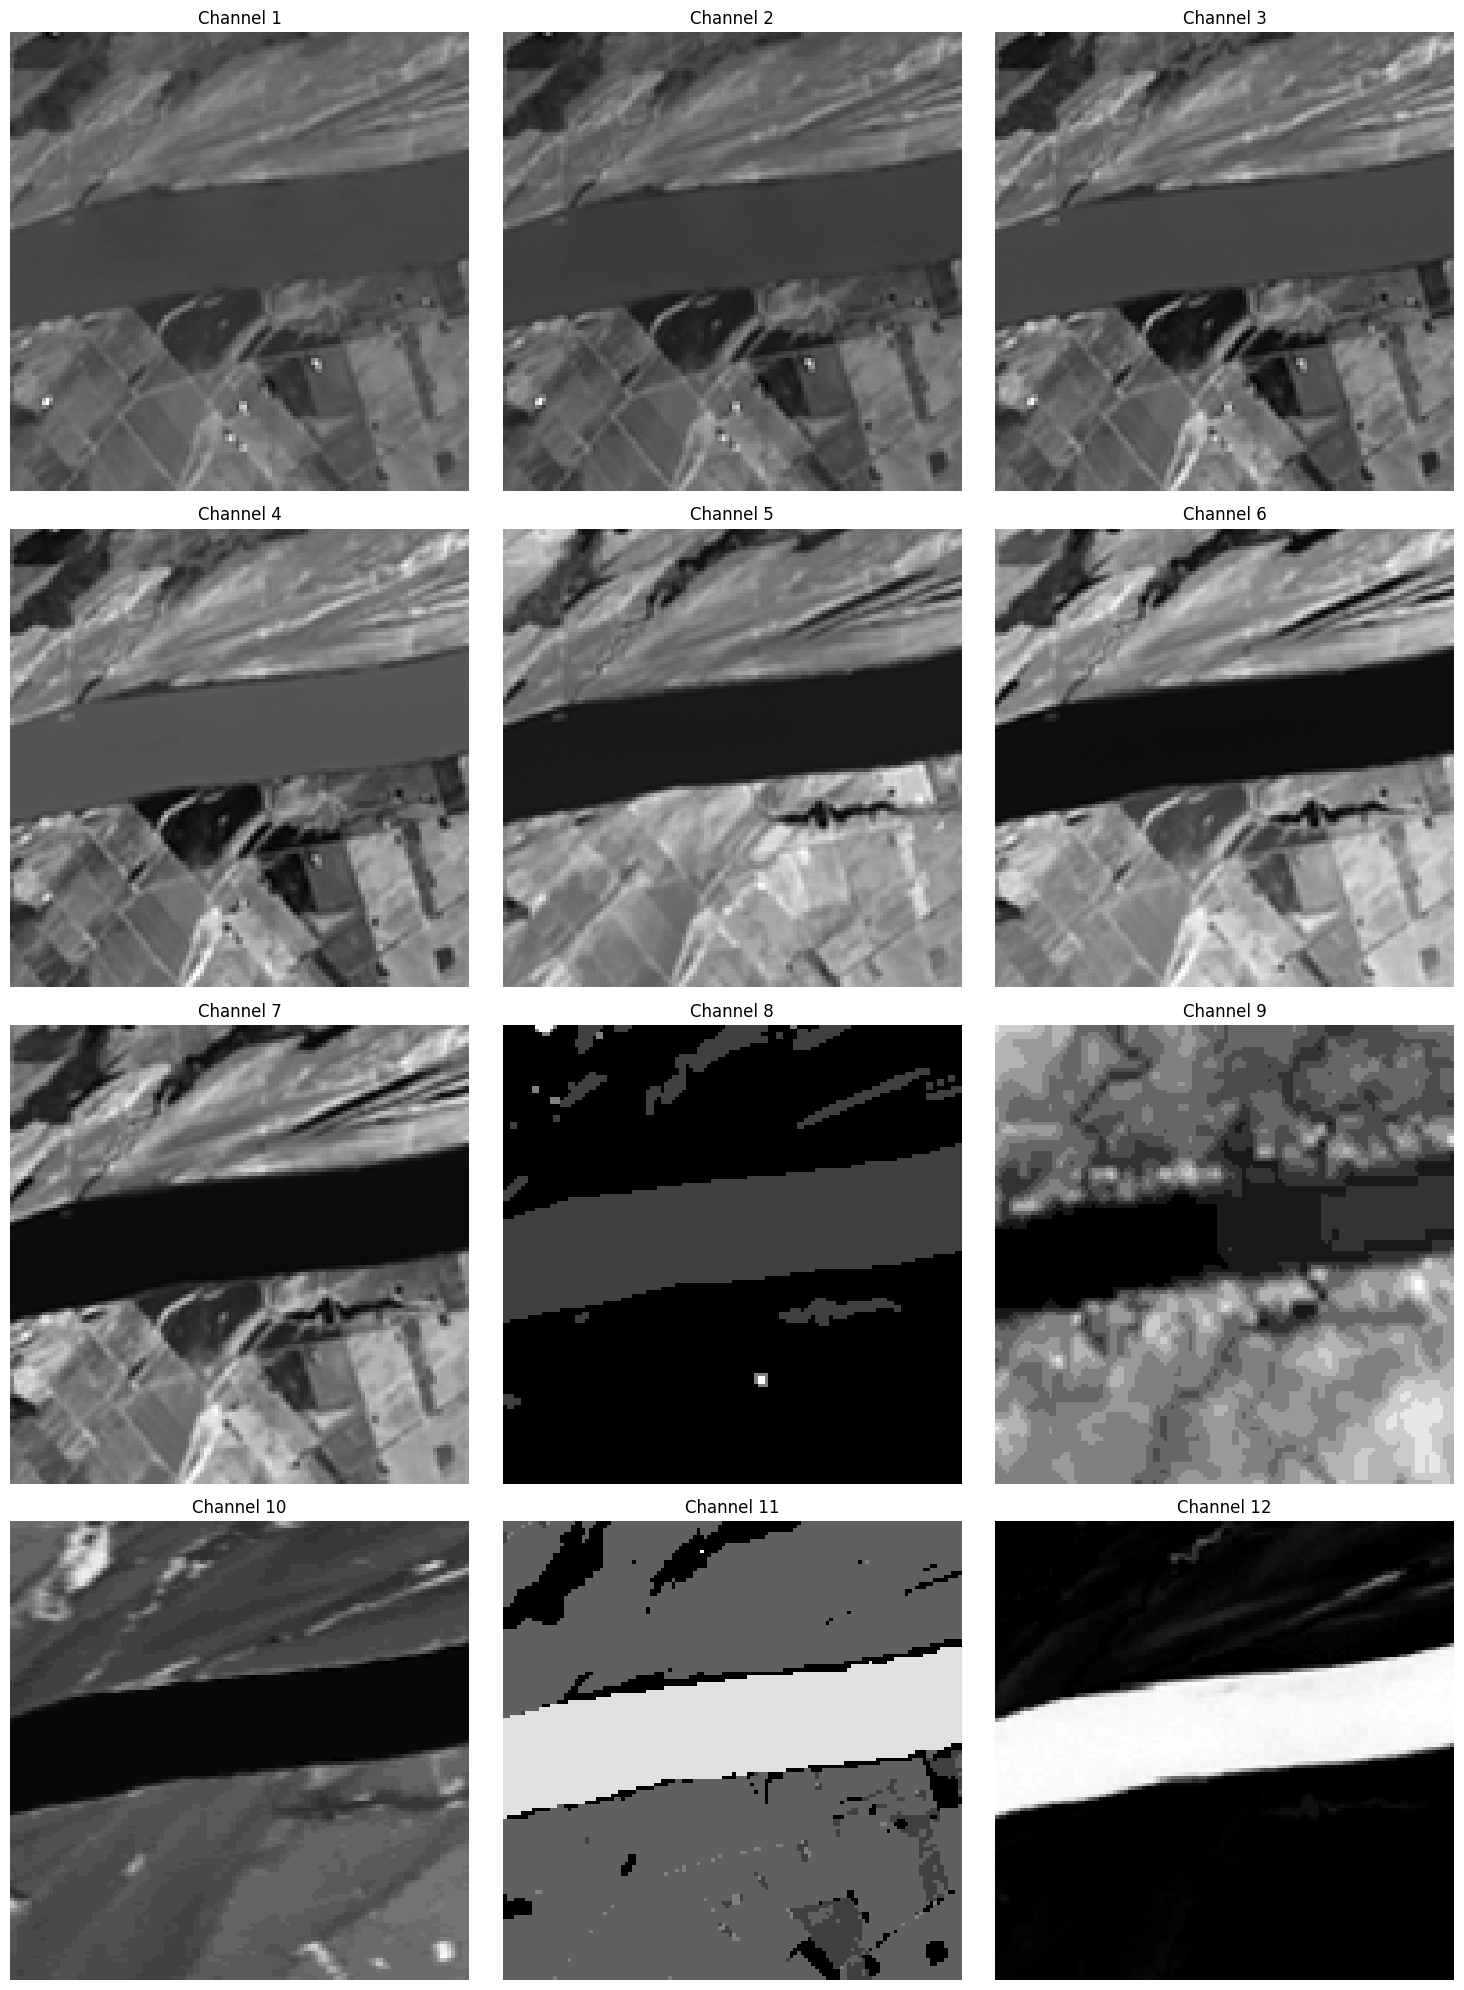

In [9]:
# Example usage
visualize_bands(images_dir)

In [10]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

Unet Model

Encoder+ Decoder

In [11]:
def encoder_block(inputs, num_filters):

    # Convolution with 3x3 filter followed by ReLU activation
    # Changed padding to same to avoid reducing the input size
    x = tf.keras.layers.Conv2D(num_filters,
                               3,
                               padding = 'same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    # Changed padding to same to avoid reducing the input size
    x = tf.keras.layers.Conv2D(num_filters,
                               3,
                               padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2),
                                  strides = 2)(x)

    return x

def decoder_block(inputs, skip_features, num_filters):

    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters,
                                        (2, 2),
                                        strides = 2,
                                        padding = 'same')(inputs)

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    # Use Keras' resize layer instead of tf.image.resize
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    # Changed padding to same to avoid reducing the input size
    x = tf.keras.layers.Conv2D(num_filters,
                               3,
                               padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    # Changed padding to same to avoid reducing the input size
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def unet_model(input_shape = (128, 128, 12)):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    # Changed padding to same to avoid reducing the input size
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'same')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    # Changed padding to same to avoid reducing the input size
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    # Changed padding to same to avoid reducing the input size
    outputs = tf.keras.layers.Conv2D(1, 1,
                                     padding = 'same',
                                     activation = 'sigmoid')(s8)

    model = tf.keras.models.Model(inputs = inputs,
                                  outputs = outputs,
                                  name = 'U-Net')
    return model

model = unet_model(input_shape=(128, 128, 12))
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 16, 16, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Check for GPU availability and configure accordingly
if len(tf.config.list_physical_devices('GPU')) > 0:
    device = '/GPU:0'
    print('GPU is available')
else:
    device = '/CPU:0'
    print('GPU is not available, using CPU instead.')

# Compile the model
with tf.device(device): # Use the appropriate device (GPU or CPU)
    model = unet_model(input_shape=(128, 128, 12))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, # Pass the entire training data
        y_train, # Pass the entire training labels
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping]
    )

GPU is available
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7268 - loss: 0.1382 - val_accuracy: 0.7756 - val_loss: 0.0200
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - accuracy: 0.7326 - loss: 0.0205 - val_accuracy: 0.7756 - val_loss: 0.0097
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.7045 - loss: 0.0117 - val_accuracy: 0.7756 - val_loss: 0.0084
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.7155 - loss: 0.0100 - val_accuracy: 0.7756 - val_loss: 0.0076
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - accuracy: 0.7209 - loss: 0.0091 - val_accuracy: 0.7756 - val_loss: 0.0075
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.7122 - loss: 0.0096 - val_accuracy: 0.7756 - val_loss: 0.0075
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.7133 - loss: 0.0093 - val_accuracy: 0.7756 - val_loss: 0.0073
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.7619 - loss: 0.0077 - val_accur

In [19]:
def preprocess_image(image_path, target_size):
    # Load the TIFF image
    img = tiff.imread(image_path)
    # Resize to the target size expected by the model
    #img = cv2.resize(img, target_size)
    # Normalize
    img_array = img.astype('float32') / 255.0
    # Expand dimensions to match the model's input shape --Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_and_show(image_path, label_path, target_size=(128, 128)):
    # Preprocess the image
    img_array = preprocess_image(image_path, target_size)
    # Make prediction
    prediction = model.predict(img_array)
    # Remove batch dimension and convert back to image
    predicted_img = np.squeeze(prediction, axis=0)
    predicted_img = array_to_img(predicted_img)
    # Load the label image
    label_img = Image.open(label_path)
    # Display the predicted image and the label side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(predicted_img, cmap='gray')
    ax[0].set_title('The Predicted Image')
    ax[0].axis('off')

    ax[1].imshow(label_img, cmap='gray')
    ax[1].set_title('The Label Image')
    ax[1].axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


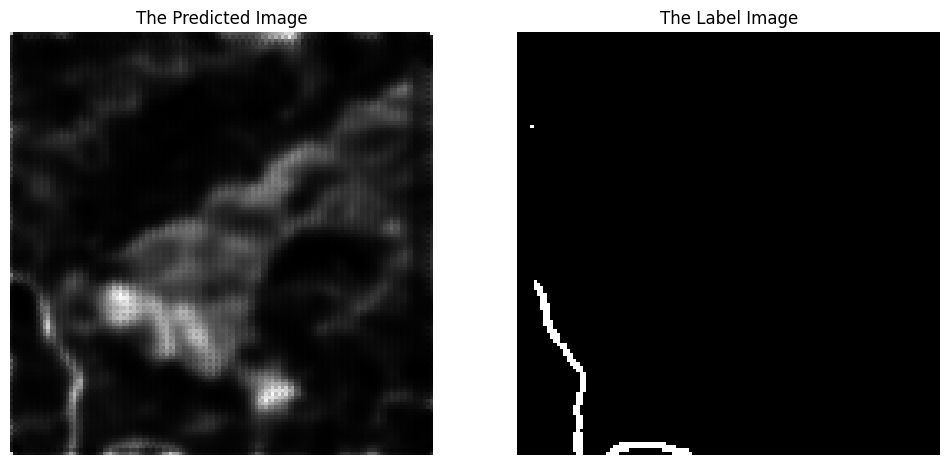

In [20]:
image_path= "/content/drive/My Drive/satalite data/data/images/1.tif"
label_path= "/content/drive/My Drive/satalite data/data/labels/1.png"
predict_and_show(image_path, label_path)